# Handling netCDF files for simple climate models

In this notebook we give a brief introduction to iris, the library we use for our analysis, before giving a demonstration of some of the key functionality of `netcdf_scm`.

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join
    
import numpy as np
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt

from netcdf_scm.iris_cube_wrappers import SCMCube, MarbleCMIP5Cube

<IPython.core.display.Javascript object>

In [2]:
plt.style.use('bmh') 
%matplotlib inline

In [3]:
DATA_PATH_TEST = join("..", "tests", "test-data")
DATA_PATH_TEST_MARBLE_CMIP5_ROOT = join(DATA_PATH_TEST, "marble-cmip5")

## Loading a cube

### Loading with iris

Here we show how to load a cube directly using iris.

In [4]:
tas_file = join(
    DATA_PATH_TEST_MARBLE_CMIP5_ROOT,
    "cmip5",
    "1pctCO2",
    "Amon",
    "tas",
    "CanESM2",
    "r1i1p1",
    "tas_Amon_CanESM2_1pctCO2_r1i1p1_185001-198912.nc",
)

In [5]:
# NBVAL_IGNORE_OUTPUT
# Ignore output as the warnings are likely to change with
# new iris versions
tas_iris_load = SCMCube()
# you need this in case your cube has multiple variables
variable_constraint = iris.Constraint(
    cube_func=(lambda c: c.var_name == np.str("tas"))
)

tas_iris_load.cube = iris.load_cube(tas_file, variable_constraint)

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


The warning tells us that we need to add the areacella as a measure variable to our cube. Doing this manually everytime involves finding the areacella file, loading it, turning it into a cell measure and then adding it to the cube. This is a pain and involves about 100 lines of code. To make life easier, we wrap all of that away using `netcdf_scm`, which we will introduce in the next section.

### Loading with `netcdf_scm`

There are a couple of particularly annoying things involved with processing netCDF data. Firstly, the data is often stored in a folder hierarchy which can be fiddly to navigate. Secondly, the metadata is often stored separate from the variable cubes. 

Hence in `netcdf_scm`, we try to abstract the code which solves these two things away to make life a bit easier. This involves defining a cube in `netcdf_scm.iris_cube_wrappers`. The details can be read there, for now we just give an example.

Our example uses `MarbleCMIP5Cube`. This cube is designed to work with the CMIP5 data on our server at University of Melbourne, which has been organised into a number of folders which are similar, but not quite identical, to the CMOR directory structure described in section 3.1 of the [CMIP5 Data Reference Syntax](https://cmip.llnl.gov/cmip5/docs/cmip5_data_reference_syntax_v1-00_clean.pdf). To facilitate our example, the test data in `DATA_PATH_TEST_MARBLE_CMIP5_ROOT` is organised in the same way.

#### Loading with identifiers

With our `MarbleCMIP5Cube`, we can simply pass in the information about the data we want (experiment, model, ensemble member etc.) and it will load our desired cube using the `load_data_from_identifiers` method.

In [6]:
tas = MarbleCMIP5Cube()
tas.load_data_from_identifiers(
    root_dir=DATA_PATH_TEST_MARBLE_CMIP5_ROOT,
    activity="cmip5",
    experiment="1pctCO2",
    modeling_realm="Amon",
    variable_name="tas",
    model="CanESM2",
    ensemble_member="r1i1p1",
    time_period="185001-198912",
    file_ext=".nc",
)

We can verify that the loaded cube is exactly the same as the cube we loaded in the previous section (where we provided the full path).

In [7]:
# NBVAL_IGNORE_OUTPUT
assert tas.cube == tas_iris_load.cube

We can have a look at our cube too (note that the broken cell measures representation is intended to be fixed in https://github.com/SciTools/iris/pull/3173).

In [8]:
tas.cube

<iris 'Cube' of air_temperature / (K) (time: 1680; latitude: 64; longitude: 128)>

#### Loading with filepath

With our `MarbleCMIP5Cube`, we can also pass in the filepath and the cube will determine the relevant attributes for us, as well as loading the other required cubes.

In [9]:
example_path = join(
    DATA_PATH_TEST_MARBLE_CMIP5_ROOT,
    "cmip5",
    "1pctCO2",
    "Amon",
    "tas",
    "CanESM2",
    "r1i1p1",
    "tas_Amon_CanESM2_1pctCO2_r1i1p1_185001-198912.nc",
)
example_path

'../tests/test-data/marble-cmip5/cmip5/1pctCO2/Amon/tas/CanESM2/r1i1p1/tas_Amon_CanESM2_1pctCO2_r1i1p1_185001-198912.nc'

In [10]:
tas_from_path = MarbleCMIP5Cube()
tas_from_path.load_data_from_path(example_path)
tas_from_path.model

'CanESM2'

We can also confirm that this cube is the same again.

In [11]:
# NBVAL_IGNORE_OUTPUT
assert tas_from_path.cube == tas_iris_load.cube

## Acting on the cube

Once we have loaded our `SCMCube`, we can act on its `cube` attribute like any other Iris Cube. For example, we can add a year categorisation, take an annual mean and then plot the timeseries.

Using DEFAULT_SPHERICAL_EARTH_RADIUS.
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


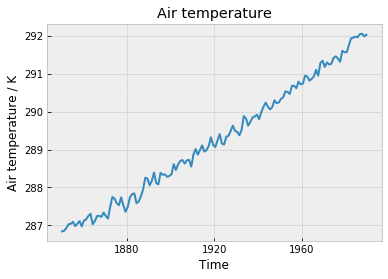

In [12]:
# NBVAL_IGNORE_OUTPUT
year_cube = tas.cube.copy()
iris.coord_categorisation.add_year(year_cube, 'time')
annual_mean = year_cube.aggregated_by(
    ['year'], # Do the averaging 
    iris.analysis.MEAN
)
global_annual_mean = annual_mean.collapsed(
    ['latitude', 'longitude'], 
    iris.analysis.MEAN,
    weights=iris.analysis.cartography.area_weights(annual_mean)
)
qplt.plot(global_annual_mean);

We can also take a time average and make a spatial plot.

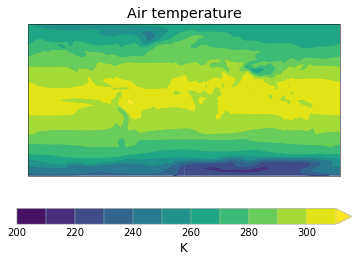

In [13]:
# NBVAL_IGNORE_OUTPUT
time_mean = tas.cube.collapsed('time', iris.analysis.MEAN)
qplt.contourf(
    time_mean, 
    levels=np.arange(200, 320, 10), 
    extend='max',
);

Add a spatial plot with coastlines.

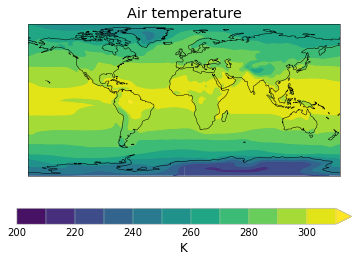

In [14]:
# NBVAL_IGNORE_OUTPUT
# we ignore output here as CI sometimes has to 
# download the map file
qplt.contourf(
    time_mean, 
    levels=np.arange(200, 320, 10), 
    extend='max',
)
plt.gca().coastlines();

## SCM specifics

Finally, we present the key functions of this package. These are directly related to processing netCDF files for simple climate models.

### Getting SCM timeseries

The major one is `get_scm_timeseries`. This function wraps a number of steps:

1. load the land surface fraction data
1. combine the land surface fraction and latitude data to determine the hemisphere and land/ocean boxes
1. cut the data into the relevant boxes
1. take a time average in each box
1. return it all as an OpenSCMDataframe

As you can imagine, we find it very useful to be able to abstract all these normally nasty steps away.

In [15]:
tas_scm_timeseries = tas.get_scm_timeseries()
type(tas_scm_timeseries)

openscm.scmdataframe.ScmDataFrame

In [16]:
tas_scm_timeseries.tail()

time                                                                                                                                   1850-01-16 12:00:00  \
model       scenario region                          variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified 1pctCO2  World|Southern Hemisphere       tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  288.649205   
                     World|Northern Hemisphere|Land  tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  271.384596   
                     World|Southern Hemisphere|Land  tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  283.334415   
                     World|Northern Hemisphere|Ocean tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  287.773688   
                     World|Southern Hemisphere|Ocean tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  289.966007   

time                                                                                                                                   1850-02-15 00:00:00  \
model       scenario region                          variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified 1pctCO2  World|Southern Hemisphere       tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  288.710473   
                     World|Northern Hemisphere|Land  tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  272.579367   
                     World|Southern Hemisphere|Land  tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  281.478725   
                     World|Northern Hemisphere|Ocean tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  287.348605   
                     World|Southern Hemisphere|Ocean tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  290.502225   

time                                                                                                                                   1850-03-16 12:00:00  \
model       scenario region                          variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified 1pctCO2  World|Southern Hemisphere       tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  288.084672   
                     World|Northern Hemisphere|Land  tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  277.906733   
                     World|Southern Hemisphere|Land  tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  278.994189   
                     World|Northern Hemisphere|Ocean tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  287.823270   
                     World|Southern Hemisphere|Ocean tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  290.336947   

time                                                                                                                                   1850-04-16 00:00:00  \
model       scenario region                          variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified 1pctCO2  World|Southern Hemisphere       tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  287.064790   
                     World|Northern Hemisphere|Land  tas      K    cmip5       CanESM2       r1i1p1    CMIP5   air_temperature                  283.299204   
                     World|Southern Hemisphere|

Having the data as a Dataframe makes it trivial to plot and work with.

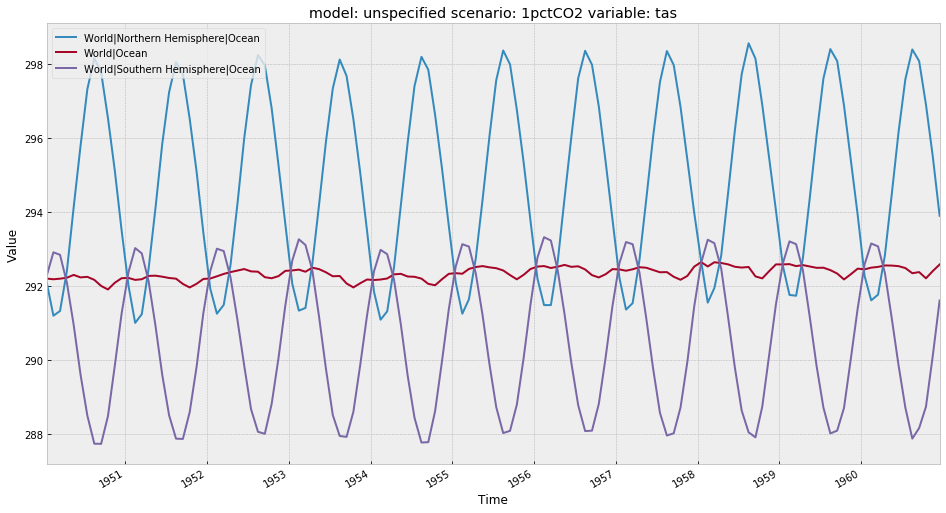

In [17]:
restricted_time_df = tas_scm_timeseries.filter(
    year=range(1950, 1961),
    region="*Ocean*"  # Try e.g. "*", "World", "*Land", "*Southern Hemisphere*" here
)
restricted_time_df.line_plot(
    x="time", 
    color="region", 
    figsize=(16, 9),
);

In [18]:
tas_scm_timeseries_annual_mean = tas_scm_timeseries.filter(
    region="World"
).timeseries().T
tas_scm_timeseries_annual_mean = tas_scm_timeseries_annual_mean.groupby(
    tas_scm_timeseries_annual_mean.index.map(lambda x: x.year)
).mean()
tas_scm_timeseries_annual_mean.head()

model,unspecified
scenario,1pctCO2
region,World
variable,tas
unit,K
activity_id,cmip5
climate_model,CanESM2
member_id,r1i1p1
mip_era,CMIP5
variable_standard_name,air_temperature
time,


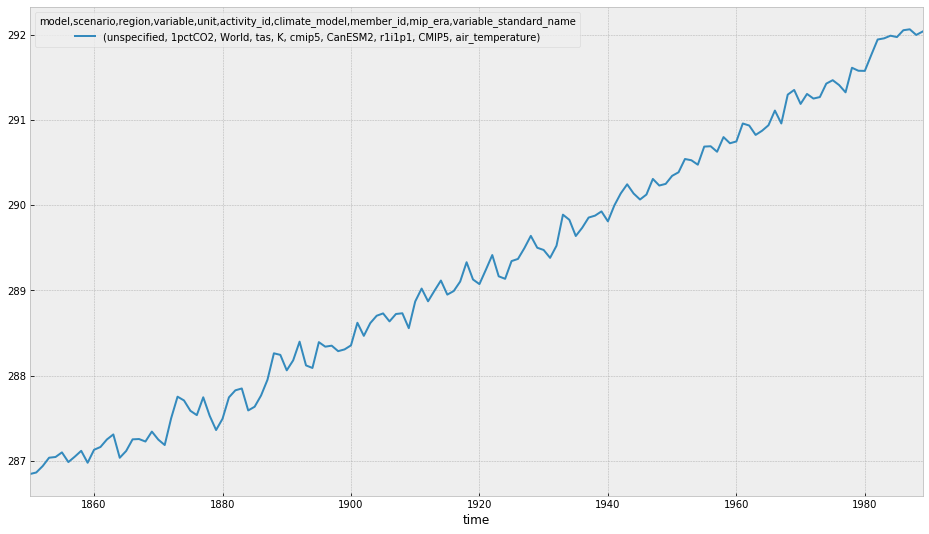

In [19]:
tas_scm_timeseries_annual_mean.plot(figsize=(16, 9));

### Getting SCM timeseries cubes

As part of the process above, we calculate all the timeseries as `iris.cube.Cube`'s. Extracting these intermediate cubes can be done with `get_scm_timeseries_cubes`. These intermediate cubes are useful as they contain all the metadata from the source cube in a slightly more friendly format than `SCMDataFrame`'s `metadata` attribute [Note: `SCMDataFrame`'s metadata handling is a work in progress]. 

In [20]:
tas_scm_ts_cubes = tas.get_scm_timeseries_cubes()

In [21]:
# NBVAL_IGNORE_OUTPUT
print(tas_scm_ts_cubes["World"].cube)

air_temperature                            (time: 1680)
     Dimension coordinates:
          time                                  x
     Scalar coordinates:
          height: 2.0 m
          land_fraction: 0.3030924179669931
          land_fraction_northern_hemisphere: 0.4076169376537766
          land_fraction_southern_hemisphere: 0.19856502699902237
          latitude: 0.0 degrees, bound=(-90.0, 90.0) degrees
          longitude: 178.59375 degrees, bound=(-1.40625, 358.59375) degrees
    Scalar cell measures:
          cell_area
     Attributes:
          CCCma_data_licence: 1) GRANT OF LICENCE - The Government of Canada (Environment Canada) is...
          CCCma_parent_runid: IGA
          CCCma_runid: IDK
          Conventions: CF-1.4
          activity_id: cmip5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_CanESM2_1pctCO2_r0i0p0.nc...
          branch_time: 171915.0
          branch_time_YMDH: 2321:01:01:00
  

In particular, the `land_fraction*` auxillary co-ordinates provide useful information about the fraction of area that was assumed to be land in the crunching.

In [22]:
tas_scm_ts_cubes["World"].cube.coords("land_fraction")

[AuxCoord(array([0.30309242]), standard_name=None, units=Unit('1'), long_name='land_fraction')]

In [23]:
tas_scm_ts_cubes["World"].cube.coords("land_fraction_northern_hemisphere")

[AuxCoord(array([0.40761694]), standard_name=None, units=Unit('1'), long_name='land_fraction_northern_hemisphere')]

### Investigating the weights

Another utility function is `get_scm_timeseries_weights`. This function is very similar to `get_scm_timeseries` but returns just the weights rather than a Dataframe. These weights are also area weighted. 

In [24]:
tas_scm_weights = tas.get_scm_timeseries_weights()

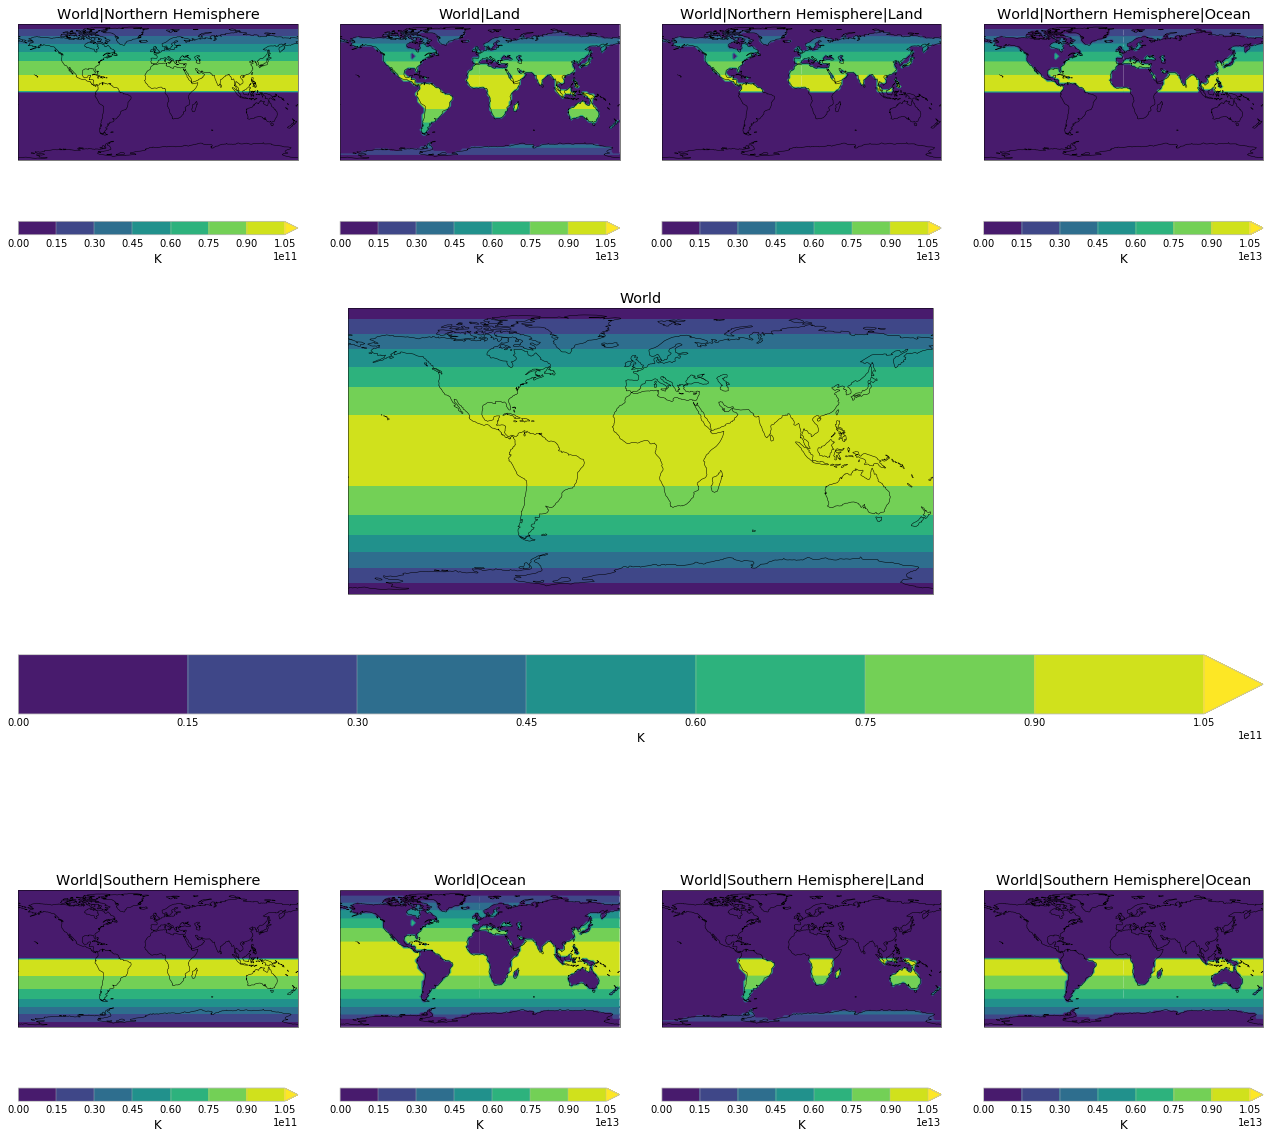

In [25]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(18, 18))
no_rows = 3
no_cols = 4

total_panels = no_cols * no_rows
rows_plt_comp = no_rows*100
cols_plt_comp = no_cols*10
for i, (label, weights) in enumerate(tas_scm_weights.items()):
    if label == "World":
        index = (int((no_rows + 1) / 2))
        plt.subplot(no_rows, 1, index)
    else:
        if label == "World|Northern Hemisphere":
            index = 1
        elif label == "World|Southern Hemisphere":
            index = 1 + (no_rows - 1) * no_cols
        elif label == "World|Land":
            index = 2
        elif label == "World|Ocean":
            index = 2 + (no_rows - 1) * no_cols
        else:
            index = 3
            if "Ocean" in label:
                index += 1
            if "Southern Hemisphere" in label:
                index += (no_rows - 1) * no_cols

        plt.subplot(no_rows, no_cols, index)
        
    weight_cube = tas.cube.copy()
    weight_cube.data = weights
    qplt.contourf(
        weight_cube.collapsed("time", iris.analysis.MEAN), 
        extend='max',
    )
    plt.title(label)
    plt.gca().coastlines()
    

plt.tight_layout()